#### Assignment 4

In [136]:
import pandas as pd
import numpy as np
from scipy import stats

# Visualization Libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objects as go

# Finance Libraries
import yfinance as yf

# Timeseries Libraries
import pmdarima # Python wrapper for R's auto.arima
from statsmodels.tsa.stattools import adfuller, kpss, acf, q_stat
from statsmodels.tsa.seasonal import seasonal_decompose # Decomposition
from statsmodels.stats.diagnostic import kstest_normal, lilliefors, acorr_ljungbox, het_breuschpagan, het_arch
from statsmodels.compat import lzip
from arch.unitroot import PhillipsPerron

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error # Shared error metrics

In [83]:
# Silence Interpolation Warnings for displaying small p-values
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.filterwarnings('ignore', category=InterpolationWarning)

In [119]:
def plot_histogram_qq(series):
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot histogram
    sns.histplot(series, ax=axes[0], kde=True)
    axes[0].set_title("Histogram")

    # Plot Q-Q plot
    stats.probplot(series, dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot")

    plt.tight_layout()
    plt.show()

In [94]:
def skew_and_kurtosis_confidence_intervals(timeseries):

    # Calculate n
    n = len(timeseries.dropna())

    # Calculate skew
    skew = timeseries.skew()
    SE_skew = np.sqrt((6*n*(n-1)) / ((n-2)*(n+1)*(n+3)))

    # Calculate kurtosis
    kurtosis = timeseries.kurtosis()
    SE_kurt = 2*SE_skew*np.sqrt((n**2-1)/(n-3))

    # Create dataframe with 95% confidence intervals
    normality_stats = pd.DataFrame({'Lower Bound':[skew - 1.96*SE_skew,kurtosis - 1.96*SE_kurt],
                                    'Data':[skew,kurtosis],
                                    'Upper Bound':[skew + 1.96*SE_skew,kurtosis + 1.96*SE_kurt]},
                                    index=['Skew','Kurtosis'])

    return(normality_stats)

In [95]:
def ComprehensiveTests(ts: pd.Series) -> pd.DataFrame:

    # Normality tests
    ShapiroStat, ShapiroP = stats.shapiro(ts)
    KsStat, KsP = stats.kstest(ts, 'norm', args=(ts.mean(), ts.std()))
    AdResult = stats.anderson(ts, dist='norm')
    JbStat, JbP = stats.jarque_bera(ts)
    AdStat = AdResult.statistic
    AdP = AdResult.critical_values[2]

    # Stationarity tests
    AdfStat, AdfP, _, _, _, _ = adfuller(ts)
    KpssStat, KpssP, _, _ = kpss(ts, nlags='auto', regression='c')
    pp_test = PhillipsPerron(ts)
    PpStat = pp_test.stat
    PpP = pp_test.pvalue

    # Autocorrelation tests
    ljung_box = acorr_ljungbox(ts, lags=1)
    ljung_box_stat = ljung_box.iloc[0, 0]
    ljung_box_pvalue = ljung_box.iloc[0, 1]

    box_pierce_stat, box_pierce_pvalue = q_stat(acf(ts, nlags=10, fft=True), len(ts))

    # Variance tests
    X = np.vstack([np.ones(len(ts)), range(len(ts))]).T
    bp_test_stat, bp_test_pvalue, _, _ = het_breuschpagan(ts, X)
    ml_test_stat, ml_test_pvalue, _, _ = het_arch(ts)
    
    # Determine results based on p-values
    normal_result = 'Normal' if (ShapiroP > 0.05) and (KsP > 0.05) and (JbP > 0.05) else 'Non-Normal'
    stationarity_result = 'Stationary' if (AdfP < 0.05) and (KpssP > 0.05) else 'Non-Stationary'
    autocorrelation_result = 'Autocorrelated' if (ljung_box_pvalue < 0.05) or (box_pierce_pvalue < 0.05) else 'Non-Autocorrelated'
    variance_result = 'Homoskedastic' if (bp_test_pvalue > 0.05) and (ml_test_pvalue > 0.05) else 'Heteroskedastic'
    
    # Compile results
    Results = pd.DataFrame({
        'Test Name': ['Shapiro-Wilk', 'Kolmogorov-Smirnov', 'Anderson-Darling', 'Jarque-Bera', 'Augmented Dickey-Fuller', 'Kwiatkowski-Phillips-Schmidt-Shin', 'Phillips-Perron',
                    'Ljung-Box', 'Box-Pierce', 'Breusch-Pagan', 'McLeod-Li'],
        'Type': ['Normality', 'Normality', 'Normality', 'Normality', 'Stationarity', 'Stationarity', 'Stationarity', 
                'Autocorrelation', 'Autocorrelation', 'Variance', 'Variance'],
        'Test Statistic': [ShapiroStat, KsStat, AdStat, JbStat, AdfStat, KpssStat, PpStat, 
                        ljung_box_stat, box_pierce_stat[0], bp_test_stat, ml_test_stat],
        'p-value': [ShapiroP, KsP, np.nan, JbP, AdfP, KpssP, PpP, 
                    ljung_box_pvalue, box_pierce_pvalue[0], bp_test_pvalue, ml_test_pvalue],
        'Result': [normal_result, normal_result, normal_result, normal_result, stationarity_result, stationarity_result, stationarity_result, 
                autocorrelation_result, autocorrelation_result, variance_result, variance_result]
    })
    
    return Results.round(3)

In [100]:
def decomposition(timeseries):

    timeseries_copy = timeseries.copy(deep=True)
    timeseries_copy = timeseries_copy.resample('D').ffill()
    decomp = seasonal_decompose(timeseries_copy)

    fig = make_subplots(rows=1,cols=3,subplot_titles=('Trend','Seasonal','Residuals'))

    fig.add_trace(px.line(decomp.trend).data[0],row=1,col=1)
    fig.add_trace(px.line(decomp.seasonal).data[0],row=1,col=2)
    fig.add_trace(px.line(decomp.resid).data[0],row=1,col=3)

    fig.update_layout(width=1950)

    fig.show()

#### Retrieve tickers

In [24]:
nikkei = yf.ticker.Ticker('EWJ') # Nikkei 225 - EWJ
hang_seng = yf.ticker.Ticker('EWH') # Hang Seng - EWH
csi = yf.ticker.Ticker('PEK') # CSI 300 - PEK
kospi = yf.ticker.Ticker('EWY') # Kospi Composite - EWY

#### Retrieve ticker history

In [25]:
nikkei_history = nikkei.history(start='2016-01-01',end='2018-01-01')
hang_seng_history = hang_seng.history(start='2016-01-01',end='2018-01-01')
csi_history = csi.history(start='2016-01-01',end='2018-01-01')
kospi_history = kospi.history(start='2016-01-01',end='2018-01-01')

#### Retrieve ticker price history

In [26]:
nikkei_price = nikkei_history.loc[:,'Close']
hang_seng_price = hang_seng_history.loc[:,'Close']
csi_price = csi_history.loc[:,'Close']
kospi_price = kospi_history.loc[:,'Close']

#### EDA

In [139]:
# Line Plots

fig = make_subplots(rows=2,cols=2,subplot_titles=('Nikkei 225','Hang Seng','CSI 300','KOSPI'))

fig.add_trace(px.line(nikkei_price).data[0],row=1,col=1)
fig.add_trace(px.line(hang_seng_price).data[0],row=1,col=2)
fig.add_trace(px.line(csi_price).data[0],row=2,col=1)
fig.add_trace(px.line(kospi_price).data[0],row=2,col=2)

fig.update_layout(height=800,width=1950)

fig.show()

In [142]:
# Line plot of normalize prices

closing_prices = pd.DataFrame({
    'Nikkei 225':nikkei_price,
    'Hang Seng':hang_seng_price,
    'CSI 300':csi_price,
    'KOSPI':kospi_price})

min_max_scaler = MinMaxScaler()

min_max_scaler.fit(closing_prices)

noramlized_closing_prices = pd.DataFrame(min_max_scaler.transform(closing_prices),index=nikkei_price.index)

noramlized_closing_prices.columns = closing_prices.columns

display(px.line(noramlized_closing_prices))

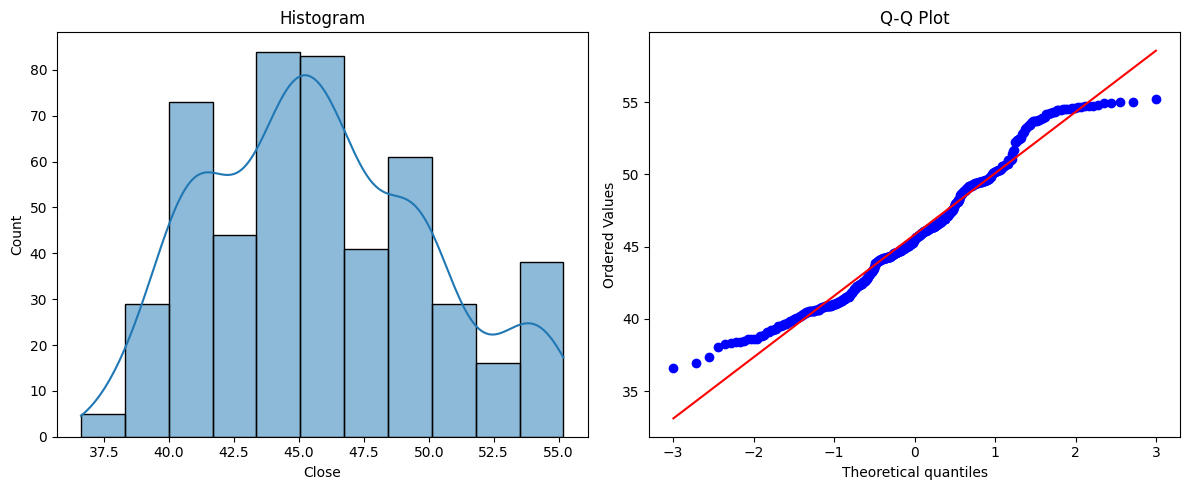

None

,Lower Bound,Data,Upper Bound
Skew,0.097510,0.310941,0.524372
Kurtosis,-10.215232,-0.613043,8.989147


,Test Name,Type,Test Statistic,p-value,Result
0,Shapiro-Wilk,Normality,0.974,0.000,Non-Normal
1,Kolmogorov-Smirnov,Normality,0.050,0.153,Non-Normal
2,Anderson-Darling,Normality,3.077,NaN,Non-Normal
3,Jarque-Bera,Normality,16.084,0.000,Non-Normal
4,Augmented Dickey-Fuller,Stationarity,0.696,0.990,Non-Stationary
5,Kwiatkowski-Phillips-Schmidt-Shin,Stationarity,3.737,0.010,Non-Stationary
6,Phillips-Perron,Stationarity,0.643,0.989,Non-Stationary
7,Ljung-Box,Autocorrelation,496.737,0.000,Autocorrelated
8,Box-Pierce,Autocorrelation,506.006,0.000,Autocorrelated
9,Breusch-Pagan,Variance,468.679,0.000,Heteroskedastic


None

In [144]:
# EDA for Nikkei

ts = nikkei_price

display(px.line(ts))
display(plot_histogram_qq(ts))
display(skew_and_kurtosis_confidence_intervals(ts))
display(ComprehensiveTests(ts))
display(decomposition(ts))

In [ ]:
# Pre-Processing of Nikkei

#### ARIMA

#### SARIMA

#### (S)ARIMA-GARCH

#### RNN

#### LSTM

#### GRU

#### Transformers